####kaggle의 레퍼런스를 따라하면서 Time Series분석을 이해함


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


############ 데이터 불러오기 ############

# df = pd.read_csv('/content/dataset.csv',index_col=False,skiprows=0)
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/project/Superstore_Sales_Dataset.csv')

############ 데이터 살펴보기 ############


# print(df)
# print(df.iloc[0])

# Row ID                                           1
# Order ID                            CA-2017-152156
# Order Date                              08/11/2017
# Ship Date                               11/11/2017
# Ship Mode                             Second Class
# Customer ID                               CG-12520
# Customer Name                          Claire Gute
# Segment                                   Consumer
# Country                              United States
# City                                     Henderson
# State                                     Kentucky
# Postal Code                                42420.0
# Region                                       South
# Product ID                         FUR-BO-10001798
# Category                                 Furniture
# Sub-Category                             Bookcases
# Product Name     Bush Somerset Collection Bookcase
# Sales                                       261.96
# Name: 0, dtype: object


# # 데이터 확인
# # print(df.info())
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 9800 entries, 0 to 9799
# Data columns (total 18 columns):
#       Column         Non-Null Count  Dtype  
# ---  ------         --------------  -----  
#  0   Row ID         9800 non-null   int64  
#  1   Order ID       9800 non-null   object 
#  2   Order Date     9800 non-null   object 
#  3   Ship Date      9800 non-null   object 
#  4   Ship Mode      9800 non-null   object 
#  5   Customer ID    9800 non-null   object 
#  6   Customer Name  9800 non-null   object 
#  7   Segment        9800 non-null   object 
#  8   Country        9800 non-null   object 
#  9   City           9800 non-null   object 
#  10  State          9800 non-null   object 
#  11  Postal Code    9789 non-null   float64
#  12  Region         9800 non-null   object 
#  13  Product ID     9800 non-null   object 
#  14  Category       9800 non-null   object 
#  15  Sub-Category   9800 non-null   object 
#  16  Product Name   9800 non-null   object 
#  17  Sales          9800 non-null   float64
# dtypes: float64(2), int64(1), object(15)
# memory usage: 1.3+ MB
# None

# #컬럼명 변경
df.rename(columns={
    'Row ID':'row_id',
    'Order ID':'order_id',
    'Order Date':'order_date',
    'Ship Date':'ship_date',
    'Ship Mode':'ship_mode',
    'Customer ID':'customer_id',
    'Customer Name':'customer_name',
    'Segment':'segment',
    'Country':'country',
    'City':'city',
    'State':'state',
    'Postal Code':'postal_code',
    'Region':'region',
    'Product ID':'product_id',
    'Category':'category',
    'Sub-Category':'sub-category',
    'Product Name':'product_name',
    'Sales':'sales'
},inplace=True)

# # 컬럼명 변경
# print(df.columns)
# # Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')
# df.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60':'passengers'},inplace=True)
# df.rename(columns={'Month':'month'},inplace=True)


# df.isna().sum() # 11
# postal_code      11
print(df[df['postal_code'].isnull()])

#         state  postal_code region       product_id         category  \
# 2234  Vermont          NaN   East  TEC-AC-10001013       Technology   
# 5274  Vermont          NaN   East  FUR-CH-10000595        Furniture   
# 8798  Vermont          NaN   East  TEC-PH-10002555       Technology   
# 9146  Vermont          NaN   East  TEC-AC-10002926       Technology   
# 9147  Vermont          NaN   East  OFF-AR-10003477  Office Supplies   
# 9148  Vermont          NaN   East  OFF-ST-10001526  Office Supplies   
# 9386  Vermont          NaN   East  OFF-PA-10000157  Office Supplies   
# 9387  Vermont          NaN   East  OFF-PA-10001970  Office Supplies   
# 9388  Vermont          NaN   East  OFF-AP-10000828  Office Supplies   
# 9389  Vermont          NaN   East  OFF-EN-10001509  Office Supplies   
# 9741  Vermont          NaN   East  FUR-BO-10004834        Furniture  

# 결측값 제거
# df.dropna(axis=0, inplace=True)
df['postal_code'] =  df['postal_code'].fillna(5401) #

# 날짜형 데이터로 변환
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])


df_1 = df.groupby('order_date')[['order_date','sales']].sum()
# # df_1.set_index('date',inplace=True)

print(df_1.index)
print(df_1.values)

# # x = df_1.index
# # y = df_1.values

# # # # 날짜형 데이터로 변환
# # # df['month'] = pd.to_datetime(df['month'])
# # # # 날짜 데이터 인덱스 설정
# # # df.set_index('month',inplace=True)

# # # 데이터 흐름 시각화
# # plt.plot(x,y)
# # plt.show()

data = df_1


      row_id        order_id  order_date   ship_date       ship_mode  \
2234    2235  CA-2018-104066  05/12/2018  10/12/2018  Standard Class   
5274    5275  CA-2016-162887  07/11/2016  09/11/2016    Second Class   
8798    8799  US-2017-150140  06/04/2017  10/04/2017  Standard Class   
9146    9147  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9147    9148  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9148    9149  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9386    9387  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9387    9388  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9388    9389  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9389    9390  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9741    9742  CA-2016-117086  08/11/2016  12/11/2016  Standard Class   

     customer_id     customer_name      segment        country        city  \
2234    QJ-19255      Quincy Jones    Corporate  United S

In [4]:
data

,sales
order_date,
2015-01-02,468.9000
2015-01-03,2203.1510
2015-01-04,119.8880
2015-01-06,5188.5200
2015-01-07,601.0240
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


In [ ]:
# 최고의 고객 찾기

top_customer = df.groupby(['customer_name']).sum().sort_values(by='sales',ascending=False).head(20)
top_customer = top_customer[['sales']].round(2)
top_customer.reset_index(inplace=True)

# 	            row_id	postal_code	sales
# customer_name			
# Sean Miller	77545	482091.0	25043.050
# Tamara Chand	75386	586036.0	19052.218
# Raymond Buch	69857	914035.0	15117.339
# Tom Ashbrook	48932	375032.0	14595.620
# Adrian Barton	130088	1359311.0	14473.571

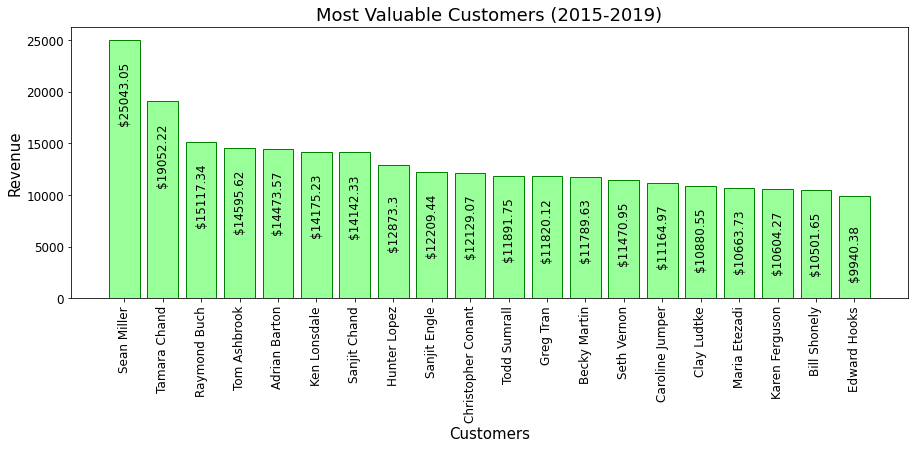

In [ ]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Most Valuable Customers (2015-2019)", fontsize=18) 
plt.bar(top_customer["customer_name"], top_customer["sales"],color= '#99ff99',edgecolor='green', linewidth = 1)
plt.xlabel("Customers",fontsize=15) # x axis shows the customers 
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

for k,v in top_customer["sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-8000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center')

In [ ]:
Top_states = df.groupby(["state"]).sum().sort_values("sales", ascending=False).head(20) # Sort the States as per the sales
Top_states = Top_states[["sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_states.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the states into dataframe


print(Top_states)

             state      sales
0       California  446306.46
1         New York  306361.15
2            Texas  168572.53
3       Washington  135206.85
4     Pennsylvania  116276.65
5          Florida   88436.53
6         Illinois   79236.52
7         Michigan   76136.07
8             Ohio   75130.35
9         Virginia   70636.72
10  North Carolina   55165.96
11         Indiana   48718.40
12         Georgia   48219.11
13        Kentucky   36458.39
14         Arizona   35272.66
15      New Jersey   34610.97
16        Colorado   31841.60
17       Wisconsin   31173.43
18       Tennessee   30661.87
19       Minnesota   29863.15


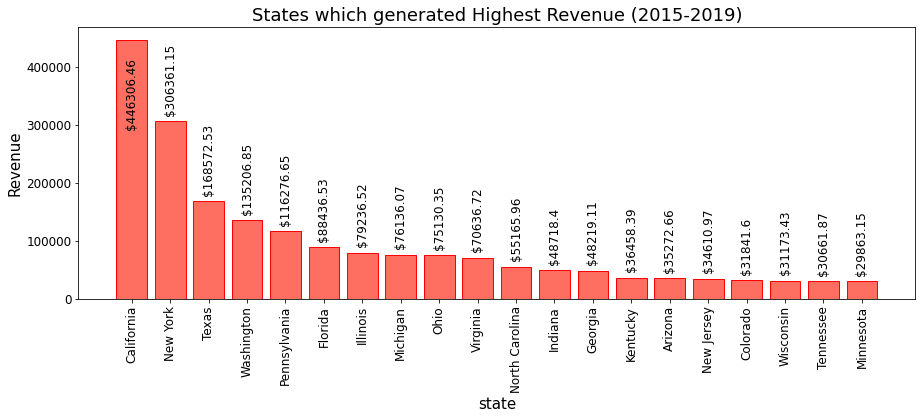

In [ ]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("States which generated Highest Revenue (2015-2019)", fontsize=18) 
plt.bar(Top_states["state"], Top_states["sales"],color= '#FF6F61',edgecolor='Red', linewidth = 1)
plt.xlabel("state",fontsize=15) # x axis shows the States
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_states["sales"].items(): #To show the exact revenue generated on the figure
    if v>400000:
        plt.text(k,v-150000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [ ]:
Top_cities = df.groupby(["city"]).sum().sort_values("sales", ascending=False).head(20) # Sort the States as per the sales
Top_cities = Top_cities[["sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_cities.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the cities into the dataframe

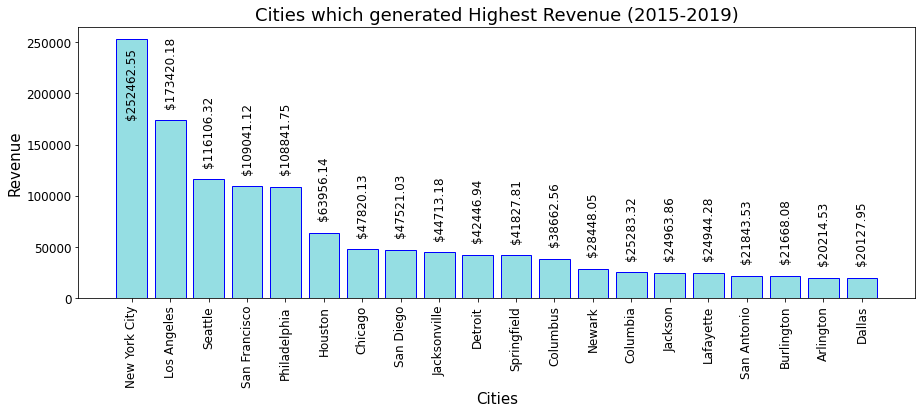

In [ ]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Cities which generated Highest Revenue (2015-2019)", fontsize=18)
plt.bar(Top_cities["city"], Top_cities["sales"],color= '#95DEE3',edgecolor='blue', linewidth = 1)
plt.xlabel("Cities",fontsize=15)  # x axis shows the States
plt.ylabel("Revenue",fontsize=15)  # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in Top_cities["sales"].items(): #To show the exact revenue generated on the figure
    if v>250000:
        plt.text(k,v-75000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [ ]:
Top_category = df.groupby(["category"]).sum().sort_values("sales", ascending=False)  # Sort the Categories as per the sales
Top_category = Top_category[["sales"]] # keep only the sales column in the dataframe
total_revenue_category = Top_category["sales"].sum() # To find the total revenue generated as per category
total_revenue_category = str(int(total_revenue_category)) # Convert the total_revenue_category from float to int and then to string
total_revenue_category = '$' + total_revenue_category # Adding '$' sign before the Value
Top_category.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the category into the dataframe

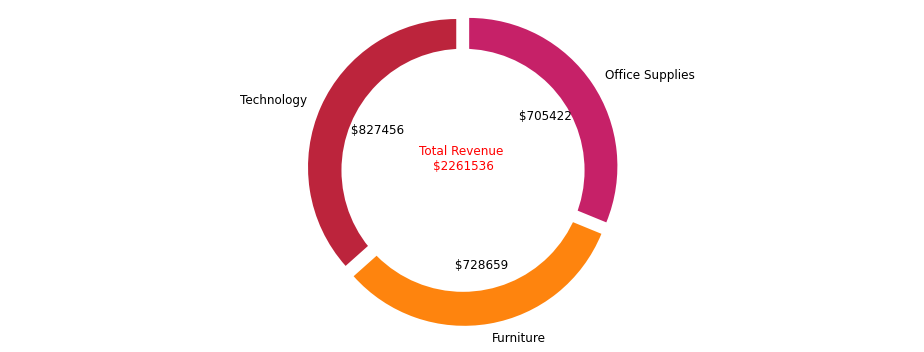

In [ ]:
plt.rcParams["figure.figsize"] = (13,5) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined
plt.rcParams['font.weight'] = 6 # Font weight is defined
# we don't want to look at the percentage distribution in the pie chart. Instead, we want to look at the exact revenue generated by the categories.
def autopct_format(values): 
    def my_format(pct): 
        total = sum(values) 
        val = int(round(pct*total/100.0))
        return ' ${v:d}'.format(v=val)
    return my_format
colors = ['#BC243C','#FE840E','#C62168'] # Colors are defined for the pie chart
explode = (0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_category['sales'], colors = colors, labels=Top_category['category'], autopct= autopct_format(Top_category['sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.82,fc='white') # drawing a circle on the pie chart to make it look better 
fig = plt.gcf()
fig.gca().add_artist(centre_circle) # Add the circle on the pie chart
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
# we can look the total revenue generated by all the categories at the center
label = ax1.annotate('Total Revenue \n'+str(total_revenue_category),color = 'red', xy=(0, 0), fontsize=12, ha="center")
plt.tight_layout()
plt.show()

In [ ]:
Top_products = df.groupby(["product_name"]).sum().sort_values("sales",ascending=False).head(8) # Sort the product names as per the sales
Top_products = Top_products[["sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_products.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the product names into the dataframe
total_revenue_products = Top_products["sales"].sum() # To find the total revenue generated by all the top products
total_revenue_products = str(int(total_revenue_products)) # Convert the total_revenue_products from float to int and then to string
total_revenue_products = '$' + total_revenue_products # Adding '$' sign before the Value

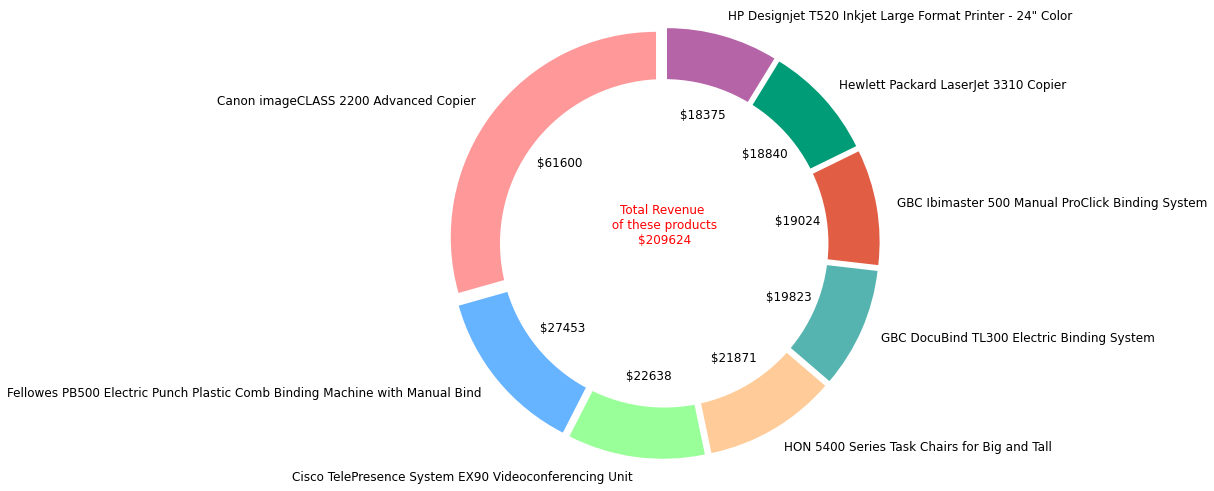

In [ ]:
plt.rcParams["figure.figsize"] = (13,7) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined for the figure
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#55B4B0','#E15D44','#009B77','#B565A7'] # colors are defined for the pie chart
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_products['sales'], colors = colors, labels=Top_products['product_name'], autopct= autopct_format(Top_products['sales']), startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.80,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
label = ax1.annotate('Total Revenue \n of these products \n'+str(total_revenue_products),color = 'red', xy=(0, 0), fontsize=12, ha="center")
plt.tight_layout()
plt.show()

In [ ]:
# Sort both category and  sub category as per the sales
Top_subcat = df.groupby(['category','sub-category']).sum().sort_values("sales", ascending=False).head(10)
Top_subcat = Top_subcat[["sales"]].astype(int) # Cast Sales column to integer data type
Top_subcat = Top_subcat.sort_values("category") # Sort the values as per Category
Top_subcat.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add both columns into data frame
Top_subcat_1 = Top_subcat.groupby(['category']).sum() # Calculated the total Sales of all the categories
Top_subcat_1.reset_index(inplace=True) # Reset the index

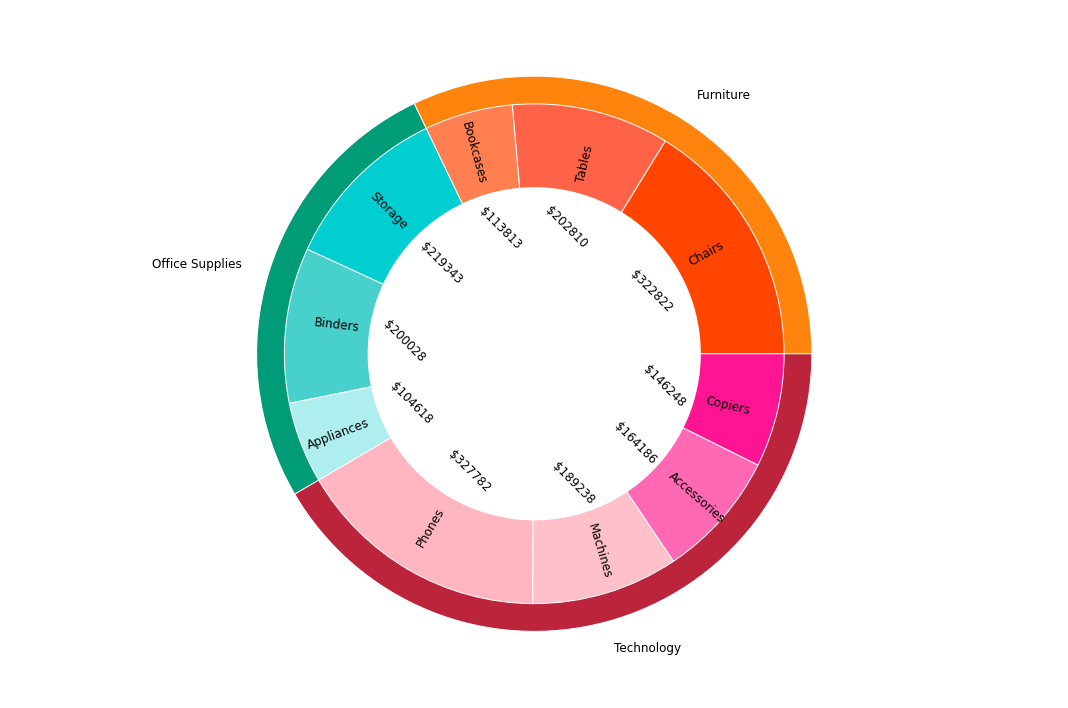

In [ ]:
plt.rcParams["figure.figsize"] = (15,10) # width and height of figure is defined in inches
fig, ax = plt.subplots()
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle
width = 0.1
outer_colors = ['#FE840E','#009B77','#BC243C'] # Outer colors of the pie chart
inner_colors = ['Orangered','tomato','coral',"darkturquoise","mediumturquoise","paleturquoise","lightpink","pink","hotpink","deeppink"] # inner colors of the pie chart
pie = ax.pie(Top_subcat_1['sales'], radius=1, labels=Top_subcat_1['category'],colors=outer_colors,wedgeprops=dict(edgecolor='w'))
pie2 = ax.pie(Top_subcat['sales'], radius=1-width, labels=Top_subcat['sub-category'],autopct= autopct_format(Top_subcat['sales']),labeldistance=0.7,colors=inner_colors,wedgeprops=dict(edgecolor='w'), pctdistance=0.53,rotatelabels =True)
# Rotate fractions
# [0] = wedges, [1] = labels, [2] = fractions
fraction_text_list = pie2[2]
for text in fraction_text_list: 
    text.set_rotation(315) # rotate the autopct values
centre_circle = plt.Circle((0,0),0.6,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [ ]:
Top_segment = df.groupby(["segment"]).sum().sort_values("sales", ascending=False) # Sort the segment as per the sales
Top_segment = Top_segment[["sales"]] # keep only the sales column in the dataframe
Top_segment.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the segment column into the data frame
total_revenue_segement = Top_segment["sales"].sum() # To find the total revenue generated as per segment
total_revenue_segement = str(int(total_revenue_segement)) # Convert the total_revenue_segment from float to int and then to string
total_revenue_segement= '$' + total_revenue_segement # Adding '$' sign before the Value

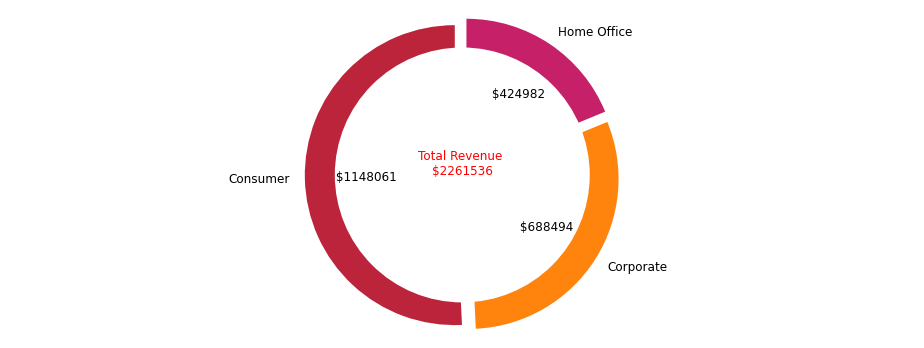

In [ ]:
plt.rcParams["figure.figsize"] = (13,5) # width and height of figure is defined in inches
plt.rcParams['font.size'] = 12.0 # Font size is defined
plt.rcParams['font.weight'] = 6 # Font weight is defined
colors = ['#BC243C','#FE840E','#C62168'] # Colors are defined for the pie chart
explode = (0.05,0.05,0.05)
fig1, ax1 = plt.subplots()
ax1.pie(Top_segment['sales'], colors = colors, labels=Top_segment['segment'], autopct= autopct_format(Top_segment['sales']),startangle=90,explode=explode)
centre_circle = plt.Circle((0,0),0.85,fc='white') # Draw a circle on the pie chart
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
label = ax1.annotate('Total Revenue \n'+str(total_revenue_segement),color = 'red', xy=(0, 0), fontsize=12, ha="center")
plt.tight_layout()
plt.show()

###상관관계 분석

Correlation of Features
By plotting a correlation matrix, we have a very nice overview of how the features are related to one another. For a Pandas dataframe, we can conveniently use the call .corr which by default provides the Pearson Correlation values of the columns pairwise in that dataframe.


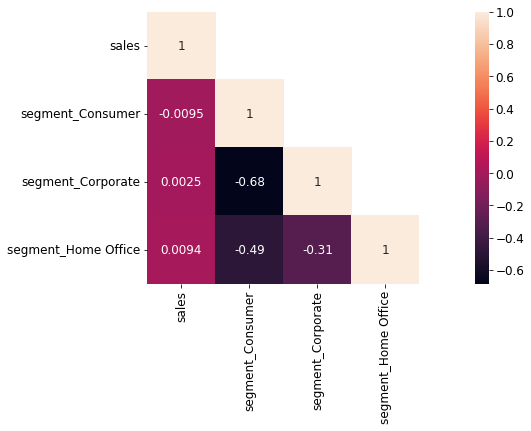

In [ ]:
df1 = df[['segment','sales']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(20,5)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

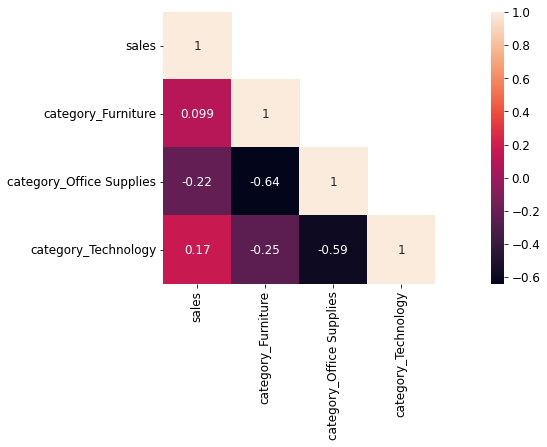

In [ ]:
df1 = df[['category','sales']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(20,5)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

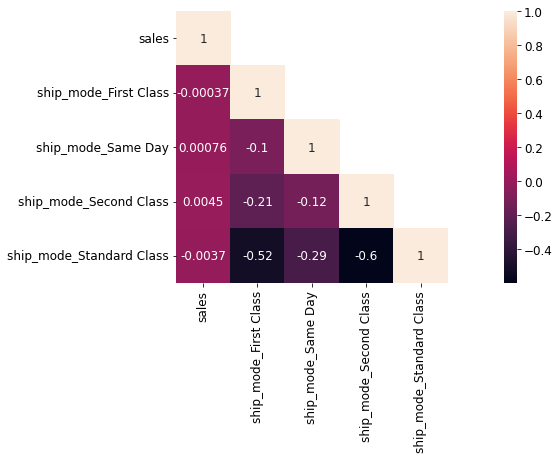

In [ ]:
df1 = df[['ship_mode','sales']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(20,5)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

In [ ]:
state = ['Alabama', 'Arizona' ,'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 
         'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
         'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana','Nebraska', 'Nevada', 'New Hampshire',
         'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
         'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
         'West Virginia', 'Wisconsin','Wyoming']
state_code = ['AL','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA',
              'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
              'TX','UT','VT','VA','WA','WV','WI','WY']

In [ ]:
state_df = pd.DataFrame(state, state_code) # Create a dataframe
state_df.reset_index(level=0, inplace=True)
state_df.columns = ['State Code','State']
sales = df.groupby(["state"]).sum().sort_values("sales", ascending=False)
sales.reset_index(level=0, inplace=True)
sales.drop('postal_code',1, inplace = True)
sales= sales.sort_values('state', ascending=True)
sales.reset_index(inplace = True)
sales.drop('index',1,inplace = True)
sales.insert(1, 'State Code', state_df['State Code'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


In [ ]:
import plotly.graph_objects as go

sales['text'] = sales['state']
fig = go.Figure(data=go.Choropleth(
    locations=sales['State Code'], # Spatial coordinates
    text=sales['text'],
    z = sales['sales'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Sales",
    
))

fig.update_layout(
    title_text = 'Sales',
    geo_scope='usa', # limite map scope to USA
)

fig.show();

In [ ]:
df.drop('row_id',axis=1,inplace=True)

In [ ]:
print('Order Date Description\n') 
print(df['order_date'].describe()) #Displays the distribution of dates in 'Order Data' column
print('\nShip Date Description\n')
print(df['ship_date'].describe()) #Displays the distribution of dates in 'Ship Data' column

Order Date Description

count                    9800
unique                   1230
top       2017-05-09 00:00:00
freq                       38
first     2015-01-02 00:00:00
last      2018-12-30 00:00:00
Name: order_date, dtype: object

Ship Date Description

count                    9800
unique                   1326
top       2018-09-26 00:00:00
freq                       34
first     2015-01-04 00:00:00
last      2019-05-01 00:00:00
Name: ship_date, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



In [ ]:
#sorting data by order date
df.sort_values(by=['order_date'], inplace=True, ascending=True) #Sorting data by  ascending order of the coloumn values 'Order Date'
df.set_index("order_date", inplace = True) #Setting 'Order Date' as index of the dataframe 'df' for ease of Time Series Analysis

In [6]:
new_data = data['sales']
new_data

order_date
2015-01-02     468.9000
2015-01-03    2203.1510
2015-01-04     119.8880
2015-01-06    5188.5200
2015-01-07     601.0240
                ...    
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Name: sales, Length: 1230, dtype: float64

In [ ]:
# # To forecast sales seven days later of the order date, let us create a new dataframe with only the target column i.e, 
# # the 'Sales' column and 'Order Date' as the index 

# new_data = pd.DataFrame(df['sales'])
# new_data

,sales
order_date,
2015-01-02,468.900
2015-01-03,5.940
2015-01-03,457.568
2015-01-03,17.472
2015-01-03,63.552
...,...
2018-12-30,52.776
2018-12-30,209.300
2018-12-30,90.930


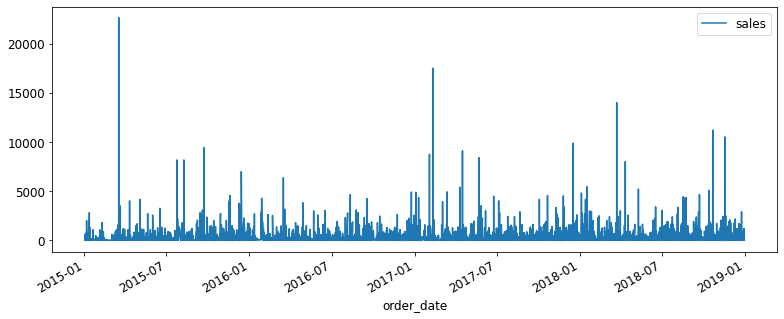

In [ ]:
#Plotting the data to understand the sales distribution from the year 2015-2018
fig = new_data.plot()

In [7]:
# # Checkting for Stationarity
new_data =  pd.DataFrame(new_data['sales'].resample('D').mean())
new_data = new_data.interpolate(method='linear') #The interpolate() function is used to interpolate values according to 
#different methods. It ignore the index and treats the values as equally spaced.


KeyError: ignored

In [8]:
# Method 1
# To check for stationarity by comparing the change in mean and variance over time, let us split the data into train, test and validate.
train, test, validate = np.split(new_data.sample(frac=1), [int(.6*len(new_data)),int(.8*len(new_data))])

In [9]:
print('Train Dataset')
print(train)
print('Test Dataset')
print(test)
print('Validate Dataset')
print(validate)

Train Dataset
order_date
2017-01-21    1167.056
2015-06-24       4.272
2015-11-27     203.660
2015-10-31    5362.026
2016-12-16       4.980
                ...   
2015-09-24     211.960
2018-01-19    2013.715
2018-09-17    4979.226
2018-03-28    1504.702
2015-05-13     898.382
Name: sales, Length: 738, dtype: float64
Test Dataset
order_date
2016-03-09    1874.898
2017-05-22    1799.200
2018-06-16    2724.194
2017-05-17     346.922
2017-04-18    2514.538
                ...   
2015-01-31     290.666
2015-10-27      22.320
2015-12-07    1960.012
2016-06-25     857.080
2018-12-20     377.736
Name: sales, Length: 246, dtype: float64
Validate Dataset
order_date
2018-01-05    4108.370
2015-05-20     320.104
2015-09-08    3605.685
2017-05-28    2137.324
2015-01-09     469.436
                ...   
2018-10-02     227.103
2018-09-22    7871.213
2018-08-23    4590.344
2015-09-22    1240.266
2018-05-06     491.112
Name: sales, Length: 246, dtype: float64


In [10]:
mean1, mean2, mean3 = train.mean(), test.mean(), validate.mean() #taking mean of train, test and validate data
var1, var2, var3 = train.var(), test.var(), validate.var() #taking variance of train, test and validate data

print('Mean:')
print(mean1, mean2, mean3)
print('Variance:')
print(var1, var2, var3)

Mean:
1791.3088970189701 2045.4426308943089 1773.8696321138214
Variance:
4362267.799052404 8486752.10147574 4767680.511901248


In [ ]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 20, 10

# import statsmodels.api as sm
# decomposition = sm.tsa.seasonal_decompose(new_data, model='additive') #function used to decompose Time Series Data into Trend and Seasonality
# fig = decomposition.plot()
# plt.show();

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(new_data, model='additive') #function used to decompose Time Series Data into Trend and Seasonality
fig = decomposition.plot()
plt.show();

ValueError: ignored

시계열 데이터가 정지 상태라는 것을 알게 되었습니다. 판매량 예측을 위한 모델 교육부터 시작하겠습니다. 우리는 매출을 예측하기 위해 SARIMA 모델을 선택했습니다.

계절 자기 회귀 통합 이동 평균, SARIMA 또는 계절 ARIMA는 계절 성분이 포함된 일변량 시계열 데이터를 지원하는 ARIMA의 확장입니다.

SARIMA에서는 시리즈의 추세 및 계절 요소 모두에 대해 하이퍼 파라미터를 선택해야 합니다.

Trend Elements 구성이 필요한 세 가지 추세 요소가 있습니다.
p: 추세 자동 회귀 순서. d: 추세 차이 순서. q: 추세 이동 평균 순서.

계절 요소 4가지 계절 요소가 있습니다.
P: 계절 자기 회귀 순서입니다. D: 계절적 차이 순서. Q: 계절 이동 평균 순서. m: 단일 계절 기간의 시간 단계 수입니다.

SARIMA 모델의 표기법은 다음과 같이 지정됩니다. SARIMA(p,d,q)(P,D,Q)m

In [ ]:
import itertools
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))
seasonal_pdq_comb = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_data,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

# **The Akaike information criterion (AIC) is an estimator of out-of-sample prediction error and thereby relative 
# quality of statistical models for a given set of data. AIC estimates the relative amount of information lost 
# by a given model. The less information a model loses, the higher the quality of that model.   

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:21256.821898557937
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:20889.30233034247
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20889.30233034247
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:21033.381884260532
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2

In [13]:
%%bash

pip3 install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [19]:
train_data,test_data = train_test_split(new_data,test_size=0.2,shuffle=False) 


In [20]:
train_data

order_date
2015-01-02     468.900
2015-01-03    2203.151
2015-01-04     119.888
2015-01-06    5188.520
2015-01-07     601.024
                ...   
2018-03-26    3252.880
2018-03-27    2933.516
2018-03-28    1504.702
2018-03-29      81.400
2018-03-30     656.407
Name: sales, Length: 984, dtype: float64

In [21]:
test_data

order_date
2018-03-31    4981.0108
2018-04-02      32.6700
2018-04-03     228.8220
2018-04-04     808.4700
2018-04-05    1146.2450
                ...    
2018-12-26     814.5940
2018-12-27     177.6360
2018-12-28    1657.3508
2018-12-29    2915.5340
2018-12-30     713.7900
Name: sales, Length: 246, dtype: float64

In [22]:
from pmdarima.arima import auto_arima
auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=2, max_q=2, m=12, seasonal=True,
                              d=1,D=1,
                              max_P=2,max_Q=2,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False
)

#파라미터를 지정해두면 자동으로 찾아주는 프로그램 pmdarima install
# start_p : p값의 최소값 (1,3)
# start_q : q값의 최소값 (1,3)
# max_p : p값의 최대값 (1,3)
# max_q : q값의 최대값 (1,3)
# d : 차분
# m : 계절성을 의미, 월별 계절성이면 12, 분기별인 경우는 4
# 나머지는 정의 안해줘도 가능

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19034.040, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=10.37 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=18741.862, Time=1.01 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.78 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=21.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18590.566, Time=2.28 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=15.20 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=13.52 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.91 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=23.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=11.86 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=inf,

In [32]:
# 예측

# prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
prediction = auto_arima_model.predict(len(test_data))
# predicted_value = prediction[0]
# predicted_ub = prediction[1][:,0]
# predicted_lb = prediction[1][:,1]
# predict_index = list(test_data.index)
# r2 = r2_score(test_data,predicted_value)

print(prediction[-5:])

[-2166.66901292 -1392.96557427 -2469.80143325  3666.37708967
 -2728.32104918]


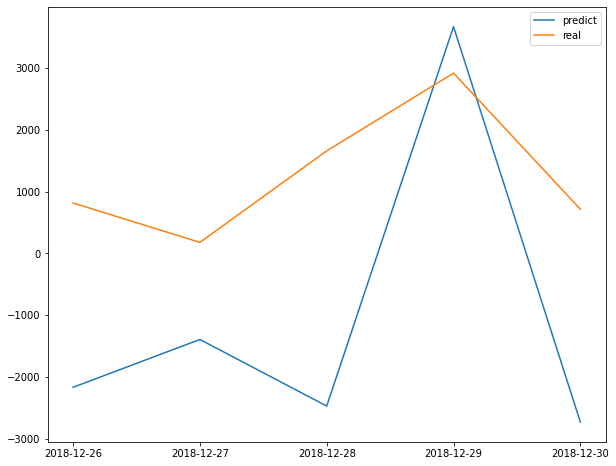

In [39]:

from pylab import rcParams
rcParams['figure.figsize'] = 10,8

plt.plot(['2018-12-26','2018-12-27','2018-12-28','2018-12-29','2018-12-30'],prediction[-5:])
plt.plot(['2018-12-26','2018-12-27','2018-12-28','2018-12-29','2018-12-30'],list(test_data)[-5:])
plt.legend(['predict', 'real'])


In [ ]:
# After choosing the combination of seasonal parameters with least AIC value, let us train the SARIMA model
mod = sm.tsa.statespace.SARIMAX(new_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False) #model defintion
results = mod.fit() #model fitting
print(results.summary().tables[1]) # displaying the result 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2720      0.011     24.206      0.000       0.250       0.294
ma.L1         -1.0000      2.516     -0.397      0.691      -5.931       3.931
ar.S.L12       0.0086      0.022      0.393      0.694      -0.034       0.051
ma.S.L12      -1.0000      2.514     -0.398      0.691      -5.928       3.928
sigma2      6.931e+04   3.57e-05   1.94e+09      0.000    6.93e+04    6.93e+04


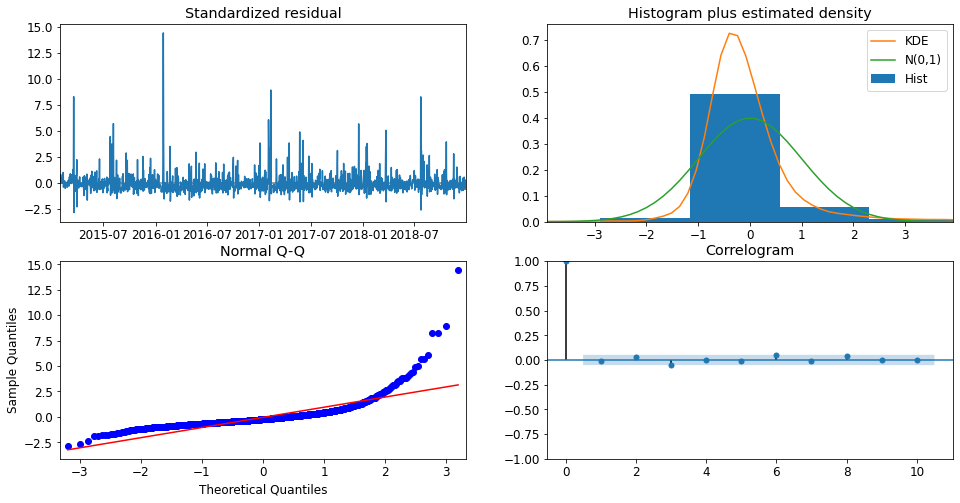

In [ ]:
results.plot_diagnostics(figsize=(16, 8)) #Produces a plot grid of: 1. Standardized residuals over time 
# 2. Histogram plus estimated density of standardized residulas and along with a Normal(0,1) density plotted for reference.
# 3. Normal Q-Q plot, with Normal reference line and, 4. Correlogram.
plt.show()

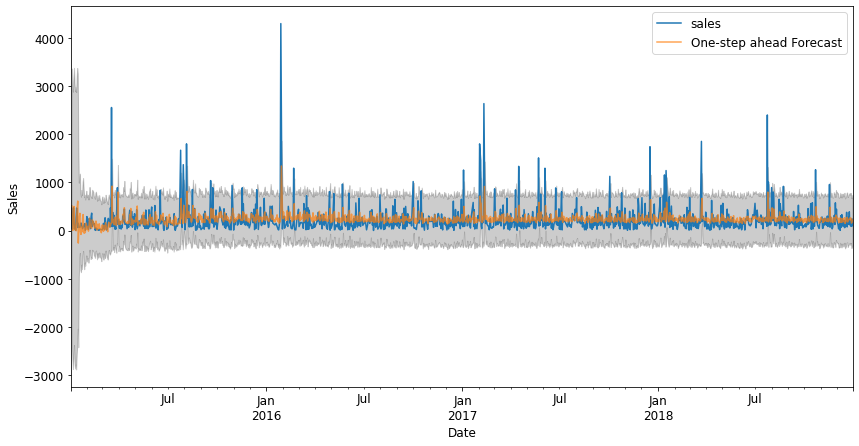

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-03'), dynamic=False) # variable to display plot for predicted values
pred_val = pred.conf_int()
ax = new_data['2014':].plot(label='observed') # displays plot for original values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7)) # displays plot for predicted values
ax.fill_between(pred_val.index,
                pred_val.iloc[:, 0],
                pred_val.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
y_forecasted = pred.predicted_mean
print(y_forecasted)

y_truth = new_data['sales'][1:]
print(y_truth)

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_forecasted, y_truth)
rmse = sqrt(mse)
print('The Mean Squared Error of the forecasts is {}'.format(round(rmse, 2))) # displays the root mean squared error of the forecast with rounding it up to 2 decimals

order_date
2015-01-03    511.410040
2015-01-04    199.598145
2015-01-05      5.034275
2015-01-06    272.034134
2015-01-07    500.185966
                 ...    
2018-12-26    218.363887
2018-12-27    260.751981
2018-12-28    154.937669
2018-12-29    176.179888
2018-12-30    220.455264
Freq: D, Length: 1458, dtype: float64
order_date
2015-01-03    220.315100
2015-01-04     29.972000
2015-01-05    250.827818
2015-01-06    471.683636
2015-01-07    200.341333
                 ...    
2018-12-26    203.648500
2018-12-27     88.818000
2018-12-28     87.228989
2018-12-29    242.961167
2018-12-30    101.970000
Freq: D, Name: sales, Length: 1458, dtype: float64
The Mean Squared Error of the forecasts is 268.19


In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(prediction, list(test_data))
rmse = sqrt(mse)
print('RMSE :  {}'.format(round(rmse, 2))) # displays the root mean squared error of the forecast with rounding it up to 2 decimals

RMSE :  4034.53


In [ ]:
# mod = sm.tsa.statespace.SARIMAX(new_data,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(1, 1, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False) #model defintion
# results = mod.fit() #model fitting

# 이후 7일의 데이터를 예측 steps = 예측
forecast = results.forecast(steps=7) # making a forecast of 7 days later of the last date in the 'Order Date' column
print(forecast.astype('int')) #displays the sales forecast as type integer

2018-12-31    248
2019-01-01    232
2019-01-02    222
2019-01-03    208
2019-01-04    208
2019-01-05    275
2019-01-06    228
Freq: D, dtype: int64


In [ ]:
forecast = forecast.astype('int') #saving the sales values as type integer
forecast_df = forecast.to_frame() # forecast is in Series form, converting it to DataFrame
forecast_df.reset_index(level=0, inplace=True) # converting the index to column
forecast_df.columns = ['Prediction Date', 'Predicted Sales'] # giving appropriate names to the output columns
prediction = pd.DataFrame(forecast_df).to_csv('prediction.csv',index=False) # saving the output as a csv file with name 'prediction.csv'